<a href="https://colab.research.google.com/github/rohitamar/VAE/blob/main/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1, bias=False)
        )

        self.mu = nn.Linear(128 * 2 * 2, latent_dim, bias=False)
        self.logvar = nn.Linear(128 * 2 * 2, latent_dim, bias=False)
        self.before_dec = nn.Linear(latent_dim, 128 * 2 * 2, bias=False)

    def decode(self, x):
        x = self.before_dec(x).view(-1, 128, 2, 2)
        return self.decoder(x)

    def reparam(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(logvar)
        return mu + eps * sigma

    def forward(self, x):
        x = self.encoder(x).view(-1, 128 * 2 * 2)
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparam(mu, logvar)
        x_r = self.decode(z)
        return x_r, mu, logvar

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

def train_model(model, dataloader, config):
    epochs = config['epochs']
    optimizer = Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = MultiStepLR(optimizer,
                            milestones = config['milestones'],
                            gamma = config['gamma'])
    beta_start, beta_end, beta_warmup = config['beta_start'], config['beta_end'], config['beta_warmup']

    avg_losses = []
    avg_recons = []
    avg_kls = []

    model = model.to(device)
    model.train()
    for epoch in range(epochs):
        beta = beta_start + (beta_end - beta_start) * min(epoch / beta_warmup, 1.0)
        avg_loss = avg_recon = avg_kl = 0.0
        iters = 0

        for step, data in enumerate(dataloader):
            input, _ = data
            input = input.to(device)
            batch_size = input.size(0)

            preds, mu, logvar = model(input)
            recon = F.binary_cross_entropy_with_logits(preds, input, reduction='sum') / batch_size
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
            loss = recon + beta * kl
            avg_loss += loss.item()
            avg_recon += recon.item()
            avg_kl += kl.item()
            iters += 1

            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        scheduler.step()
        avg_loss /= iters
        avg_recon /= iters
        avg_kl /= iters

        print(f"Epoch {epoch} - Recon: {avg_recon} KL: {avg_kl} Both: {avg_loss}")
        avg_losses.append(avg_loss)
        avg_recons.append(avg_recon)
        avg_kls.append(avg_kl)

    return avg_losses, avg_recons, avg_kls

In [ ]:
model = CVAE(128)

loss, recon, kl = train_model(model, train_loader, {
    'epochs': 50,
    'learning_rate': 1e-3,
    'milestones': [25, 40],
    'gamma': 0.5,
    'beta_start': 0.0,
    'beta_end': 0.05,
    'beta_warmup': 35
})

Epoch 0 - Recon: 1731.32891046875 KL: 697.5697207861328 Both: 1731.32891046875
Epoch 1 - Recon: 1731.3010887304688 KL: 487.49664912109375 Both: 1731.9975129882812
Epoch 2 - Recon: 1730.8445666210937 KL: 439.25754895996096 Both: 1732.099586953125
Epoch 3 - Recon: 1730.5602209179688 KL: 408.5215505712891 Both: 1732.311028125
Epoch 4 - Recon: 1730.1231325585939 KL: 385.55952215820315 Both: 1732.3263294335939
Epoch 5 - Recon: 1730.0697481835937 KL: 369.05464436523437 Both: 1732.7058524023437
Epoch 6 - Recon: 1729.6000354492187 KL: 355.770284765625 Both: 1732.6494947265626
Epoch 7 - Recon: 1729.5119830664062 KL: 345.4716184765625 Both: 1732.9666994921874
Epoch 8 - Recon: 1729.3153012695313 KL: 336.97138317382814 Both: 1733.166403125
Epoch 9 - Recon: 1729.0618999804688 KL: 329.2198496044922 Both: 1733.2947272460938
Epoch 10 - Recon: 1728.95051078125 KL: 322.2337102978516 Both: 1733.5538491796874
Epoch 11 - Recon: 1728.7143040234375 KL: 316.0173545849609 Both: 1733.68029015625
Epoch 12 - Reco

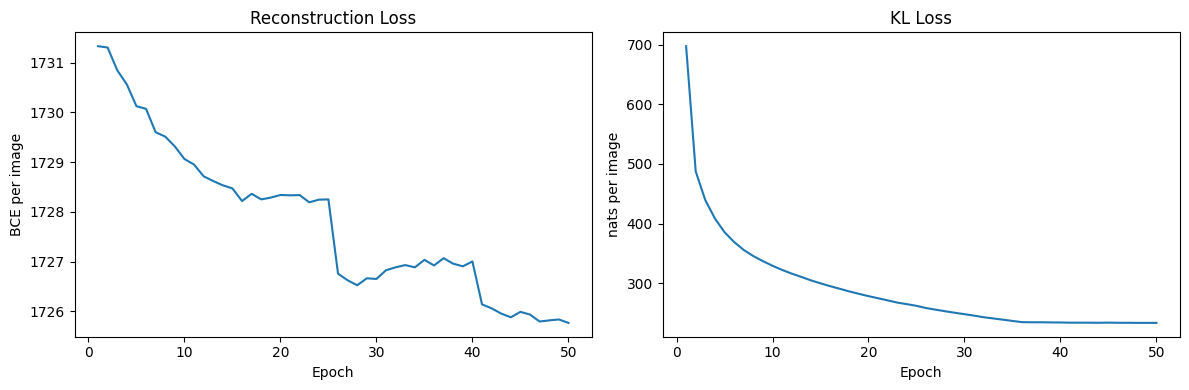

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))   # 1 row, 2 columns
axes[0].plot(range(1, len(recon) + 1), recon)
axes[0].set_title("Reconstruction Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE per image")

axes[1].plot(range(1, len(kl) + 1), kl)
axes[1].set_title("KL Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("nats per image")

plt.tight_layout()
plt.show()

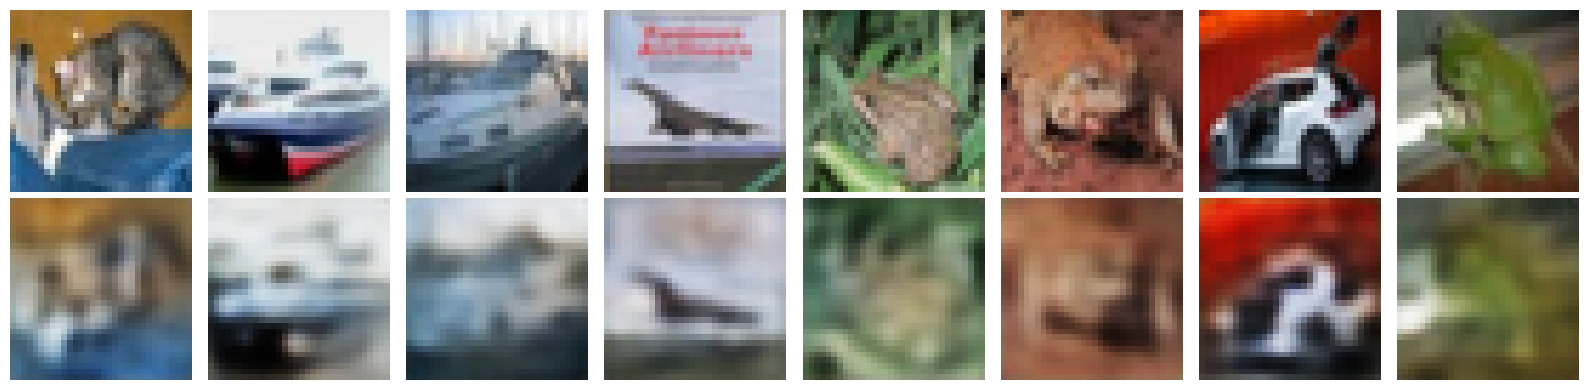

In [ ]:
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    logits, _, _ = model(x)
    recon = torch.sigmoid(logits)

n = 8
plt.figure(figsize=(2 * n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    img = x[i].cpu().permute(1, 2, 0).clamp(0, 1)
    ax.imshow(img)
    ax.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    img_r = recon[i].cpu().permute(1, 2, 0).clamp(0, 1)
    ax.imshow(img_r)
    ax.axis("off")

plt.tight_layout()
plt.show()

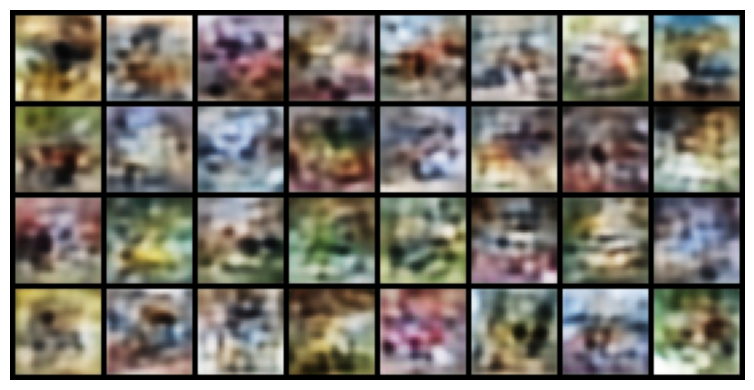

In [ ]:
from torchvision.utils import make_grid

model.eval()

z = torch.randn(32, 128, device='cuda')

with torch.no_grad():
    logits  = model.decode(z)
    samples = torch.sigmoid(logits).cpu()

grid = make_grid(samples, nrow=8)
plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()